**Importar** **Librerías**


In [15]:
import pandas as pd
import numpy as np
pd.set_option("display.max_columns", None)
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import urllib.request as ur
from scipy.interpolate import InterpolatedUnivariateSpline
import warnings
warnings.filterwarnings("ignore")
from sklearn.impute import KNNImputer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import scale
from matplotlib.pyplot import xticks
from sklearn.manifold import TSNE
from sklearn.manifold import Isomap
import pickle


**Importar** **Dataset**


In [16]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("miguelroca/global-health-nutrition-mortality-economic-data")

print("Path to dataset files:", path)

100%|██████████| 2.30M/2.30M [00:00<00:00, 92.8MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/miguelroca/global-health-nutrition-mortality-economic-data/versions/1


In [17]:
def histNaNs(df):
    df.reset_index(drop=True, inplace=True)
    nans = []
    for i in range(df.shape[0]):
        nans.append(df.loc[i].isna().sum().sum())
    n_nans = np.array(nans)
    sns.histplot(n_nans)

In [18]:
def countriesGraph(df, countries, feature, figsize=(15,10)):
    fig = plt.figure(figsize=figsize)
    ax1 = fig.add_axes([0,0,1,1])
    for country in countries:
        m = df[(df['Country']==country)& (df['Gender']=='Both sexes')][['Year', feature]].dropna().values
        x = m[:,0]
        y = m[:,1]
        ax1.plot(x,y, label=country)
    fig.legend(fontsize=10)

In [19]:
#Número de NaNs que hay por fila
def nans_per_row(df):
    nans = []
    for i in range(df.shape[0]):
        nans.append(df.loc[i].isna().sum())
    return np.array(nans)

In [20]:
#Número de NaNs que hay por país
def nans_per_country(df):
    nans = []
    nans_country = []
    for i in range(df.shape[0]):
        nans.append(df.loc[i].isna().sum())
        nans_country.append(df.loc[i]['Country'])
    # n_nans = np.array(nans)
    df_nans_countries = pd.DataFrame()
    df_nans_countries['Country'] = nans_country
    df_nans_countries['NaNs'] = nans
    return df_nans_countries

In [21]:
# Detección de outliers mediante el método del rango intercuartílico
def find_outliers_IQR(x):
    q1 = np.percentile(x,25)
    q3 = np.percentile(x,75)
    floor = q1 - 1.5 * (q3-q1)
    ceiling = q3 + 1.5 * (q3-q1)
    outlier_values = x[(x < floor)|(x>ceiling)]
    print(f'Ceiling: {ceiling} \nFloor: {floor}')
    return outlier_values

In [22]:
# Variable que controla que no se ejecute dos veces la limpieza del dataset(daría error) durante el análisis y después
wrongValuesDeleted = False

In [23]:
import os

# List files in the downloaded path to find the CSV file
files_in_path = os.listdir(path)
print(f"Files in dataset directory: {files_in_path}")

# Assuming there's a CSV file, let's try to load the first one found.
# You might need to adjust this if there are multiple CSVs or a specific one.
csv_file = [f for f in files_in_path if f.endswith('.csv')][0]
df = pd.read_csv(os.path.join(path, csv_file))

df.info()

Files in dataset directory: ['UnifiedDataset.csv']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22050 entries, 0 to 22049
Columns: 150 entries, Country to Diet Calories Carbohydrates
dtypes: float64(147), int64(1), object(2)
memory usage: 25.2+ MB


In [24]:
df.describe()

,Year,Life Expectancy,Infant Mortality Rate,Low CI Value Infant Mortality Rate,High CI Value Infant Mortality Rate,Under 5 Mortality Rate,Low CI Value Under 5 Mortality Rate,High CI Value Under 5 Mortality Rate,% Death Cardiovascular,Low CI Value % Death Cardiovascular,High CI Value % Death Cardiovascular,Suicides Rate,Alcohol Abuse,Air Pollution Death Rate Stroke,Low CI Value Air Pollution Death Rate Stroke,High CI Value Air Pollution Death Rate Stroke,Air Pollution Death Rate Stroke Age Standarized,Low CI Value Air Pollution Death Rate Stroke Age Standarized,High CI Value Air Pollution Death Rate Stroke Age Standarized,Air Pollution Death Rate Ischaemic Heart Disease,Low CI Value Air Pollution Death Rate Ischaemic Heart Disease,High CI Value Air Pollution Death Rate Ischaemic Heart Disease,Air Pollution Death Rate Ischaemic Heart Disease Age Standarized,Low CI Value Air Pollution Death Rate Ischaemic Heart Disease Age Standarized,High CI Value Air Pollution Death Rate Ischaemic Heart Disease Age Standarized,Air Pollution Death Rate Lower Respiratory Infections,Low CI Value Air Pollution Death Rate Lower Respiratory Infections,High CI Value Air Pollution Death Rate Lower Respiratory Infections,Air Pollution Death Rate Lower Respiratory Infections Age Standarized,Low CI Value Air Pollution Death Rate Lower Respiratory Infections Age Standarized,High CI Value Air Pollution Death Rate Lower Respiratory Infections Age Standarized,Air Pollution Death Rate Chronic Obstructive Pulmonary Disease,Low CI Value Air Pollution Death Rate Chronic Obstructive Pulmonary Disease,High CI Value Air Pollution Death Rate Chronic Obstructive Pulmonary Disease,Air Pollution Death Rate Chronic Obstructive Pulmonary Disease Age Standarized,Low CI Value Air Pollution Death Rate Chronic Obstructive Pulmonary Disease Age Standarized,High CI Value Air Pollution Death Rate Chronic Obstructive Pulmonary Disease Age Standarized,Air Pollution Death Rate Total,Low CI Value Air Pollution Death Rate Total,High CI Value Air Pollution Death Rate Total,Air Pollution Death Rate Total Age Standarized,Low CI Value Air Pollution Death Rate Total Age Standarized,High CI Value Air Pollution Death Rate Total Age Standarized,Air Pollution Death Rate Trachea Bronchus Lung Cancers,Low CI Value Air Pollution Death Rate Trachea Bronchus Lung Cancers,High CI Value Air Pollution Death Rate Trachea Bronchus Lung Cancers,Air Pollution Death Rate Trachea Bronchus Lung Cancers Age Standarized,Low CI Value Air Pollution Death Rate Trachea Bronchus Lung Cancers Age Standarized,High CI Value Air Pollution Death Rate Trachea Bronchus Lung Cancers Age Standarized,Unsafe Wash Mortality Rate,Poisoning Mortality Rate,Tobacco Prevalence,% Population Aged 0-14,% Population Aged 15-64,% Population Aged 65+,% Population Aged 65-69,% Population Aged 70-74,% Population Aged 75-79,% Population Aged 80+,Maternal Mortality Ratio,Low CI Value Maternal Mortality Ratio,High CI Value Maternal Mortality Ratio,% of Births Attended By Skilled Personal,Neonatal Mortality Rate,Low CI Value Neonatal Mortality Rate,High CI Value Neonatal Mortality Rate,Incidence of Malaria,Incidence of Tuberculosis,Low CI Value Incidence of Tuberculosis,High CI Value Incidence of Tuberculosis,Hepatitis B Surface Antigen,Low CI Value Hepatitis B Surface Antigen,High CI Value Hepatitis B Surface Antigen,Intervention Against NTDs,Road Traffic Deaths,Reproductive Age Women,Adolescent Birth Rate,Universal Heath Care Coverage,Population 10 Percentage SDG Total,Population 10 Percentage SDG Urban,Population 10 Percentage SDG Rural,Population 25 Percentage SDG Total,Population 25 Percentage SDG Urban,Population 25 Percentage SDG Rural,Doctors,Nurses and Midwifes,Dentists,Pharmacists,Basic Drinking Water Services,Basic Sanization Services Total,Basic Sanization Services Urban,Basic Sanization Services Rural,Safely Sanitation Total,Safely Sanitation Urban,Safely Sanitation Rural,Basic Hand Washing Total,Basic Hand Washing Urban,Basic Ha

In [25]:
df[['Life Expectancy']].describe()

,Life Expectancy
count,22050.000000
mean,69.011830
std,9.691938
min,24.834000
25%,63.082000
50%,71.134000
75%,76.254000
max,87.747000


<Axes: xlabel='Life Expectancy', ylabel='Count'>

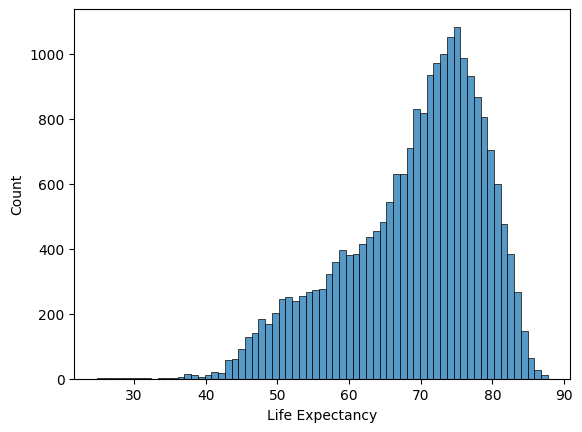

In [26]:
sns.histplot(df['Life Expectancy'])

Text(0, 0.5, 'Density')

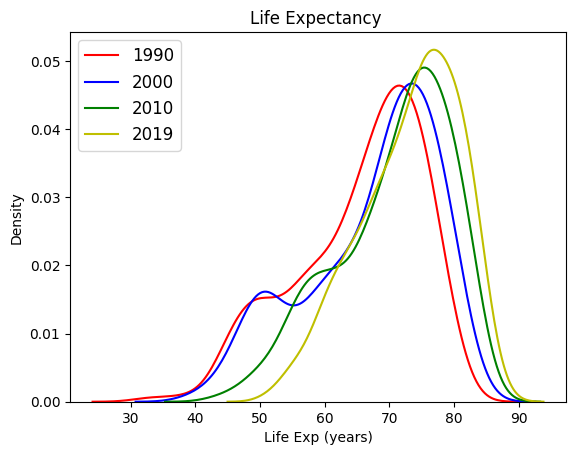

In [27]:
sns.distplot(df['Life Expectancy'][df['Year'] == 1990], hist=False, label='1990', color='r')
sns.distplot(df['Life Expectancy'][df['Year'] == 2000], hist=False, label='2000', color='b')
sns.distplot(df['Life Expectancy'][df['Year'] == 2010], hist=False, label='2010', color='g')
sns.distplot(df['Life Expectancy'][df['Year'] == 2019], hist=False, label='2019', color='y')
plt.legend(prop={'size': 12})
plt.title('Life Expectancy ')
plt.xlabel('Life Exp (years)')
plt.ylabel('Density')




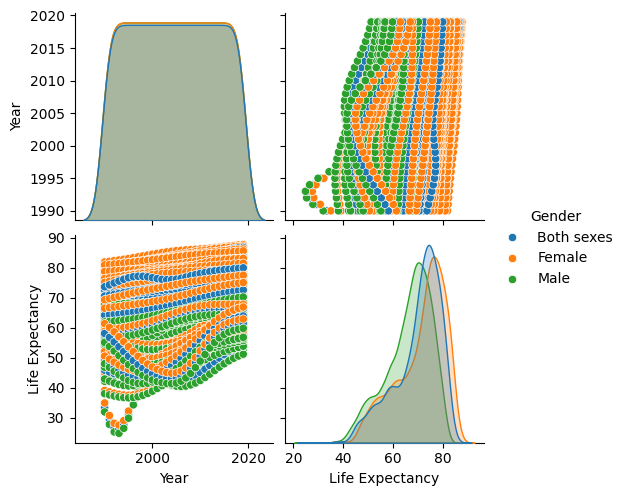

In [28]:
sns.pairplot(df[['Year', 'Gender', 'Life Expectancy']], hue='Gender')


In [29]:
df[df['Life Expectancy'] < 40][['Country','Year', 'Gender', 'Life Expectancy']]

,Country,Year,Gender,Life Expectancy
16410,Rwanda,1990,Both sexes,33.413
16411,Rwanda,1990,Female,34.941
16412,Rwanda,1990,Male,31.941
16413,Rwanda,1991,Both sexes,29.248
16414,Rwanda,1991,Female,30.761
16415,Rwanda,1991,Male,27.800
16416,Rwanda,1992,Both sexes,26.691
16417,Rwanda,1992,Female,28.161
16418,Rwanda,1992,Male,25.288
16419,Rwanda,1993,Both sexes,26.172


In [30]:
df[df['Life Expectancy'] < 40].describe()

,Year,Life Expectancy,Infant Mortality Rate,Low CI Value Infant Mortality Rate,High CI Value Infant Mortality Rate,Under 5 Mortality Rate,Low CI Value Under 5 Mortality Rate,High CI Value Under 5 Mortality Rate,% Death Cardiovascular,Low CI Value % Death Cardiovascular,High CI Value % Death Cardiovascular,Suicides Rate,Alcohol Abuse,Air Pollution Death Rate Stroke,Low CI Value Air Pollution Death Rate Stroke,High CI Value Air Pollution Death Rate Stroke,Air Pollution Death Rate Stroke Age Standarized,Low CI Value Air Pollution Death Rate Stroke Age Standarized,High CI Value Air Pollution Death Rate Stroke Age Standarized,Air Pollution Death Rate Ischaemic Heart Disease,Low CI Value Air Pollution Death Rate Ischaemic Heart Disease,High CI Value Air Pollution Death Rate Ischaemic Heart Disease,Air Pollution Death Rate Ischaemic Heart Disease Age Standarized,Low CI Value Air Pollution Death Rate Ischaemic Heart Disease Age Standarized,High CI Value Air Pollution Death Rate Ischaemic Heart Disease Age Standarized,Air Pollution Death Rate Lower Respiratory Infections,Low CI Value Air Pollution Death Rate Lower Respiratory Infections,High CI Value Air Pollution Death Rate Lower Respiratory Infections,Air Pollution Death Rate Lower Respiratory Infections Age Standarized,Low CI Value Air Pollution Death Rate Lower Respiratory Infections Age Standarized,High CI Value Air Pollution Death Rate Lower Respiratory Infections Age Standarized,Air Pollution Death Rate Chronic Obstructive Pulmonary Disease,Low CI Value Air Pollution Death Rate Chronic Obstructive Pulmonary Disease,High CI Value Air Pollution Death Rate Chronic Obstructive Pulmonary Disease,Air Pollution Death Rate Chronic Obstructive Pulmonary Disease Age Standarized,Low CI Value Air Pollution Death Rate Chronic Obstructive Pulmonary Disease Age Standarized,High CI Value Air Pollution Death Rate Chronic Obstructive Pulmonary Disease Age Standarized,Air Pollution Death Rate Total,Low CI Value Air Pollution Death Rate Total,High CI Value Air Pollution Death Rate Total,Air Pollution Death Rate Total Age Standarized,Low CI Value Air Pollution Death Rate Total Age Standarized,High CI Value Air Pollution Death Rate Total Age Standarized,Air Pollution Death Rate Trachea Bronchus Lung Cancers,Low CI Value Air Pollution Death Rate Trachea Bronchus Lung Cancers,High CI Value Air Pollution Death Rate Trachea Bronchus Lung Cancers,Air Pollution Death Rate Trachea Bronchus Lung Cancers Age Standarized,Low CI Value Air Pollution Death Rate Trachea Bronchus Lung Cancers Age Standarized,High CI Value Air Pollution Death Rate Trachea Bronchus Lung Cancers Age Standarized,Unsafe Wash Mortality Rate,Poisoning Mortality Rate,Tobacco Prevalence,% Population Aged 0-14,% Population Aged 15-64,% Population Aged 65+,% Population Aged 65-69,% Population Aged 70-74,% Population Aged 75-79,% Population Aged 80+,Maternal Mortality Ratio,Low CI Value Maternal Mortality Ratio,High CI Value Maternal Mortality Ratio,% of Births Attended By Skilled Personal,Neonatal Mortality Rate,Low CI Value Neonatal Mortality Rate,High CI Value Neonatal Mortality Rate,Incidence of Malaria,Incidence of Tuberculosis,Low CI Value Incidence of Tuberculosis,High CI Value Incidence of Tuberculosis,Hepatitis B Surface Antigen,Low CI Value Hepatitis B Surface Antigen,High CI Value Hepatitis B Surface Antigen,Intervention Against NTDs,Road Traffic Deaths,Reproductive Age Women,Adolescent Birth Rate,Universal Heath Care Coverage,Population 10 Percentage SDG Total,Population 10 Percentage SDG Urban,Population 10 Percentage SDG Rural,Population 25 Percentage SDG Total,Population 25 Percentage SDG Urban,Population 25 Percentage SDG Rural,Doctors,Nurses and Midwifes,Dentists,Pharmacists,Basic Drinking Water Services,Basic Sanization Services Total,Basic Sanization Services Urban,Basic Sanization Services Rural,Safely Sanitation Total,Safely Sanitation Urban,Safely Sanitation Rural,Basic Hand Washing Total,Basic Hand Washing Urban,Basic Ha

Ceiling: 96.01200000000001 
Floor: 43.324


<Axes: xlabel='Life Expectancy', ylabel='Density'>

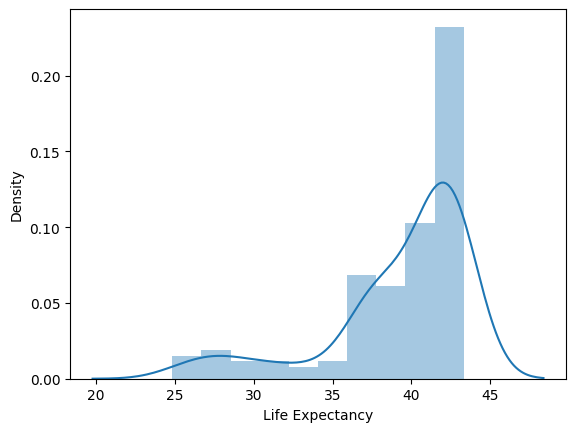

In [31]:
outliers_LifeExpectancy = find_outliers_IQR(df['Life Expectancy'])
sns.distplot(outliers_LifeExpectancy)

<Axes: xlabel='Year', ylabel='Life Expectancy'>

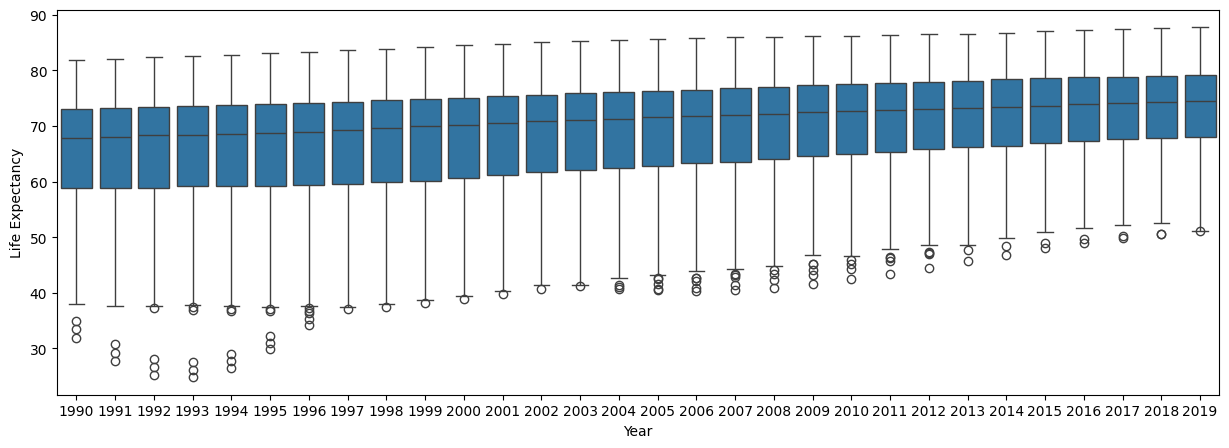

In [32]:
plt.figure(figsize=(15,5))
sns.boxplot(x='Year', y='Life Expectancy', data=df)



--- Matrice de Confusion (Régression Logistique) ---


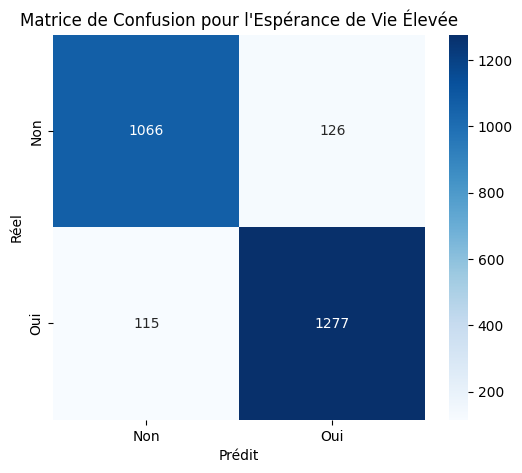

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

print("\n--- Matrice de Confusion (Régression Logistique) ---")

# IMPORTANT: Ensure the logistic regression model has been run first
# to define y_test_logistic and y_pred_logistic.

if 'y_test_logistic' in locals() and 'y_pred_logistic' in locals():
    cm = confusion_matrix(y_test_logistic, y_pred_logistic)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Non', 'Oui'], yticklabels=['Non', 'Oui'])
    plt.xlabel('Prédit')
    plt.ylabel('Réel')
    plt.title('Matrice de Confusion pour l\'Espérance de Vie Élevée')
    plt.show()
else:
    print("Erreur: Les variables 'y_test_logistic' ou 'y_pred_logistic' ne sont pas définies.")
    print("Veuillez exécuter la cellule de régression logistique ('logistic_regression_final_gen_2' par exemple) d'abord.")


--- Courbe ROC (Régression Logistique) ---


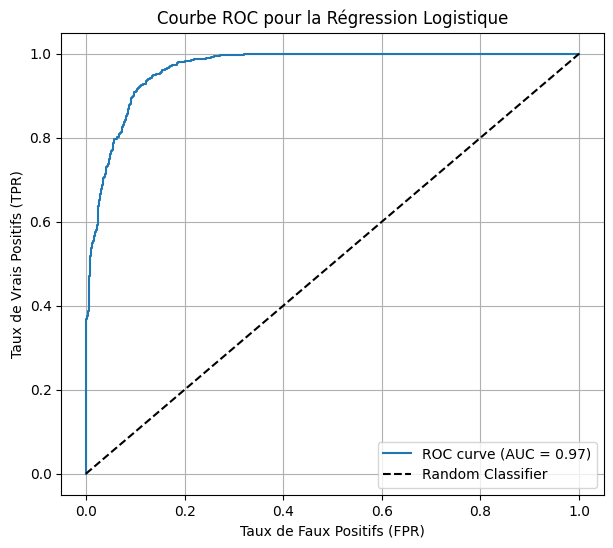

In [39]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

print("\n--- Courbe ROC (Régression Logistique) ---")

# IMPORTANT: Ensure the logistic regression model has been run first
# to define y_test_logistic and model_logistic.

if 'y_test_logistic' in locals() and 'model_logistic' in locals():
    # Get predicted probabilities for the positive class
    y_pred_proba_logistic = model_logistic.predict_proba(X_test_logistic)[:, 1]

    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_test_logistic, y_pred_proba_logistic)
    auc = roc_auc_score(y_test_logistic, y_pred_proba_logistic)

    plt.figure(figsize=(7, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    plt.xlabel('Taux de Faux Positifs (FPR)')
    plt.ylabel('Taux de Vrais Positifs (TPR)')
    plt.title('Courbe ROC pour la Régression Logistique')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()
else:
    print("Erreur: Les variables 'y_test_logistic' ou 'model_logistic' ne sont pas définies.")
    print("Veuillez exécuter la cellule de régression logistique ('logistic_regression_final_gen_2' par exemple) d'abord.")